In [77]:
import os 
import pandas as pd
import re
from datetime import datetime, timedelta
from scipy.stats import iqr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

# Eventos Críticos

In [2]:
acled = pd.read_csv("../../../Data/ACLED Colombia (2018-01-01-2023-10-31).csv", sep = ";")

# Arreglamos los formatos de fecha
acled["timestamp"] = acled["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x))
acled["event_date"] = pd.to_datetime(acled["event_date"])

inter_code_dict = {1: "State Forces", 2: "Rebel Groups", 3: "Political Militias", 4: "Identity Militias", 
                   5: "Rioters", 6: "Protesters", 7: "Civilians", 8: "External/Other Force"}

acled['inter1'] = acled['inter1'].map(inter_code_dict)

interaction_code_dict = {10: "SOLE STATE FORCES ACTION", 11: "STATE FORCES VERSUS STATE FORCES", 12: "STATE FORCES VERSUS REBELS",
                         13: "STATE FORCES VERSUS POLITICAL MILITIA", 14: "STATE FORCES VERSUS IDENTITY MILITIA", 
                         15: "STATE FORCES VERSUS RIOTERS", 16: "STATE FORCES VERSUS PROTESTERS", 17: "STATE FORCES VERSUS CIVILIANS",
                         18: "STATE FORCES VERSUS EXTERNAL/OTHER FORCES", 20: "SOLE REBEL ACTION",
                         22: "REBELS VERSUS REBELS", 23: "REBELS VERSUS POLITICAL MILITIA", 24: "REBELS VERSUS IDENTITY MILITIA",
                         25: "REBELS VERSUS RIOTERS", 26: "REBELS VERSUS PROTESTERS", 27: "REBELS VERSUS CIVILIANS", 28: "REBELS VERSUS OTHERS",
                         30: "SOLE POLITICAL MILITIA ACTION", 33: "POLITICAL MILITIA VERSUS POLITICAL MILITIA", 34: "POLITICAL MILITIA VERSUS IDENTITY MILITIA",
                         35: "POLITICAL MILITIA VERSUS RIOTERS", 36: "POLITICAL MILITIA VERSUS PROTESTERS", 37: "POLITICAL MILITIA VERSUS CIVILIANS",
                         38: "POLITICAL MILITIA VERSUS OTHERS", 40: "SOLE IDENTITY MILITIA ACTION", 44: "IDENTITY MILITIA VERSUS IDENTITY MILITIA",
                         45: "IDENTITY MILITIA VERSUS RIOTERS", 46: "IDENTITY MILITIA VERSUS PROTESTERS", 47: "IDENTITY MILITIA VERSUS CIVILIANS",
                         48: "IDENTITY MILITIA VERSUS OTHER", 50: "SOLE RIOTER ACTION", 55: "RIOTERS VERSUS RIOTERS", 56: "RIOTERS VERSUS PROTESTERS",
                         57: "RIOTERS VERSUS CIVILIANS", 58: "RIOTERS VERSUS OTHERS", 60: "SOLE PROTESTER ACTION", 66: "PROTESTERS VERSUS PROTESTERS",
                         67: "PROTESTERS VERSUS CIVILIANS", 68: "PROTESTERS VERSUS OTHER", 70: "SOLE CIVILIAN ACTION", 77: "CIVILIANS VERSUS CIVILIANS",
                         78: "OTHER ACTOR VERSUS CIVILIANS", 80: "SOLE OTHER ACTION", 88: "OTHER VERSUS OTHER"}

acled['interaction'] = acled['interaction'].map(interaction_code_dict)

In [3]:
eventos_diarios = acled[["event_id_cnty", "event_date"]].drop_duplicates().groupby(["event_date"]).size().reset_index(name = "n")

# Filtramos fechas
eventos_diarios = eventos_diarios.loc[eventos_diarios["event_date"].between('2021-04-27', '2021-06-29')]

# Vamos a encontrar número de eventos anómalos
corte1 = eventos_diarios["n"].mean() + eventos_diarios["n"].std()
print((eventos_diarios["n"] > corte1).mean()) # 12.5%

corte2 = eventos_diarios["n"].mean() + 2*eventos_diarios["n"].std()
print((eventos_diarios["n"] > corte2).mean()) # 6.25%

corte3 = np.percentile(eventos_diarios["n"], 75) + 1.5 * iqr(eventos_diarios["n"])
print((eventos_diarios["n"] > corte3).mean()) # 6.25%

0.125
0.0625
0.0625


In [4]:
fechas_criticas1 = eventos_diarios.loc[eventos_diarios["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values

In [5]:
dias_criticos = {i: ["Eventos"] for i in fechas_criticas1}

In [6]:
serie_disorder_type = acled[["event_id_cnty", "event_date", "disorder_type"]].drop_duplicates().reset_index(drop = True)
# Tenemos entradas como "Political violence; Demonstrations". Queremos partir en dos estos eventos
s = serie_disorder_type['disorder_type'].str.split('; ', expand=True).stack()
s.index = s.index.droplevel(-1)  
s.name = 'disorder_type'  
# Eliminamos la columna original para cambiarla por la nueva
del serie_disorder_type['disorder_type']
# Se pega la columna nueva en la base original
serie_disorder_type = serie_disorder_type.join(s)
serie_disorder_type = serie_disorder_type.reset_index(drop=True)
# Contamos ocurrencias
serie_disorder_type = serie_disorder_type.groupby(["event_date", "disorder_type"]).size().reset_index(name = "n")
# Filtramos fechas
serie_disorder_type = serie_disorder_type.loc[serie_disorder_type["event_date"].between('2021-04-27', '2021-06-29')]

In [7]:
serie_disorder_type2 = serie_disorder_type[serie_disorder_type["disorder_type"] == "Political violence"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_disorder_type2["n"].mean() + serie_disorder_type2["n"].std()
print((serie_disorder_type2["n"] > corte1).mean()) # 18.75%

corte2 = serie_disorder_type2["n"].mean() + 2*serie_disorder_type2["n"].std()
print((serie_disorder_type2["n"] > corte2).mean()) # 1.56%

corte3 = np.percentile(serie_disorder_type2["n"], 75) + 1.5 * iqr(serie_disorder_type2["n"])
print((serie_disorder_type2["n"] > corte3).mean()) # 0.0%

serie_disorder_type2.loc[serie_disorder_type2["n"] > corte2, ]

0.1875
0.015625
0.0


,event_date,disorder_type,n
2659,2021-05-04,Political violence,15


In [8]:
fechas_criticas2 = serie_disorder_type2.loc[serie_disorder_type2["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values

In [9]:
for i in fechas_criticas2:
    if dias_criticos.get(i):
        dias_criticos[i].append("Violencia política")
    else:
        dias_criticos[i] = ["Violencia política"]

In [10]:
dias_criticos

{'2021-04-28': ['Eventos'],
 '2021-05-03': ['Eventos'],
 '2021-05-04': ['Eventos', 'Violencia política'],
 '2021-05-05': ['Eventos']}

In [11]:
serie_event_type = acled[["event_id_cnty", "event_date", "event_type"]].drop_duplicates() \
    .groupby(["event_date", "event_type"]).size().reset_index(name = "n")
# Filtramos fechas
serie_event_type = serie_event_type.loc[serie_event_type["event_date"].between('2021-04-27', '2021-06-29')]

serie_sub_event_type = acled[["event_id_cnty", "event_date", "sub_event_type"]].drop_duplicates() \
    .groupby(["event_date", "sub_event_type"]).size().reset_index(name = "n")
# Filtramos fechas
serie_sub_event_type = serie_sub_event_type.loc[serie_sub_event_type["event_date"].between('2021-04-27', '2021-06-29')]

In [12]:
serie_event_type2 = serie_event_type[serie_event_type["event_type"] == "Violence against civilians"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_event_type2["n"].mean() + serie_event_type2["n"].std()
print((serie_event_type2["n"] > corte1).mean()) 

corte2 = serie_event_type2["n"].mean() + 2*serie_event_type2["n"].std()
print((serie_event_type2["n"] > corte2).mean()) 

corte3 = np.percentile(serie_event_type2["n"], 75) + 1.5 * iqr(serie_event_type2["n"])
print((serie_event_type2["n"] > corte3).mean())

serie_event_type2.loc[serie_event_type2["n"] > corte2, ]

0.2222222222222222
0.015873015873015872
0.015873015873015872


,event_date,event_type,n
4536,2021-06-20,Violence against civilians,11


In [13]:
fechas_criticas3 = serie_event_type2.loc[serie_event_type2["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values
fechas_criticas3

array(['2021-06-20'], dtype=object)

In [14]:
for i in fechas_criticas3:
    if dias_criticos.get(i):
        dias_criticos[i].append("Violencia contra civiles")
    else:
        dias_criticos[i] = ["Violencia contra civiles"]
dias_criticos

{'2021-04-28': ['Eventos'],
 '2021-05-03': ['Eventos'],
 '2021-05-04': ['Eventos', 'Violencia política'],
 '2021-05-05': ['Eventos'],
 '2021-06-20': ['Violencia contra civiles']}

In [15]:
serie_sub_event_type.groupby("sub_event_type")["n"].sum().sort_values(ascending = False).head()

sub_event_type
Peaceful protest             1299
Violent demonstration         343
Attack                        274
Armed clash                   123
Protest with intervention      67
Name: n, dtype: int64

In [16]:
serie_sub_event_type2 = serie_sub_event_type[serie_sub_event_type["sub_event_type"] == "Violent demonstration"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_sub_event_type2["n"].mean() + serie_sub_event_type2["n"].std()
print((serie_sub_event_type2["n"] > corte1).mean()) 

corte2 = serie_sub_event_type2["n"].mean() + 2*serie_sub_event_type2["n"].std()
print((serie_sub_event_type2["n"] > corte2).mean()) 

corte3 = np.percentile(serie_sub_event_type2["n"], 75) + 1.5 * iqr(serie_sub_event_type2["n"])
print((serie_sub_event_type2["n"] > corte3).mean())

serie_sub_event_type2.loc[serie_sub_event_type2["n"] > corte2, ]

0.1509433962264151
0.09433962264150944
0.03773584905660377


,event_date,sub_event_type,n
5061,2021-05-01,Violent demonstration,18
5074,2021-05-03,Violent demonstration,18
5084,2021-05-04,Violent demonstration,23
5092,2021-05-05,Violent demonstration,18
5437,2021-06-28,Violent demonstration,21


In [17]:
fechas_criticas4 = serie_sub_event_type2.loc[serie_sub_event_type2["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values
fechas_criticas4

array(['2021-05-01', '2021-05-03', '2021-05-04', '2021-05-05',
       '2021-06-28'], dtype=object)

In [18]:
for i in fechas_criticas4:
    if dias_criticos.get(i):
        dias_criticos[i].append("Protestas violentas")
    else:
        dias_criticos[i] = ["Protestas violentas"]
dias_criticos

{'2021-04-28': ['Eventos'],
 '2021-05-03': ['Eventos', 'Protestas violentas'],
 '2021-05-04': ['Eventos', 'Violencia política', 'Protestas violentas'],
 '2021-05-05': ['Eventos', 'Protestas violentas'],
 '2021-06-20': ['Violencia contra civiles'],
 '2021-05-01': ['Protestas violentas'],
 '2021-06-28': ['Protestas violentas']}

In [19]:
serie_disorder_type3 = serie_sub_event_type[serie_sub_event_type["sub_event_type"] == "Attack"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_disorder_type3["n"].mean() + serie_disorder_type3["n"].std()
print((serie_disorder_type3["n"] > corte1).mean()) 

corte2 = serie_disorder_type3["n"].mean() + 2*serie_disorder_type3["n"].std()
print((serie_disorder_type3["n"] > corte2).mean()) 

corte3 = np.percentile(serie_disorder_type3["n"], 75) + 1.5 * iqr(serie_disorder_type3["n"])
print((serie_disorder_type3["n"] > corte3).mean())

serie_disorder_type3.loc[serie_disorder_type3["n"] > corte2, ]

0.1746031746031746
0.031746031746031744
0.015873015873015872


,event_date,sub_event_type,n
5113,2021-05-09,Attack,9
5391,2021-06-20,Attack,11


In [20]:
fechas_criticas5 = serie_disorder_type3.loc[serie_disorder_type3["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values
fechas_criticas5

array(['2021-05-09', '2021-06-20'], dtype=object)

In [21]:
for i in fechas_criticas5:
    if dias_criticos.get(i):
        dias_criticos[i].append("Ataques")
    else:
        dias_criticos[i] = ["Ataques"]
dias_criticos

{'2021-04-28': ['Eventos'],
 '2021-05-03': ['Eventos', 'Protestas violentas'],
 '2021-05-04': ['Eventos', 'Violencia política', 'Protestas violentas'],
 '2021-05-05': ['Eventos', 'Protestas violentas'],
 '2021-06-20': ['Violencia contra civiles', 'Ataques'],
 '2021-05-01': ['Protestas violentas'],
 '2021-06-28': ['Protestas violentas'],
 '2021-05-09': ['Ataques']}

In [22]:
filtro = acled["interaction"].isin(["STATE FORCES VERSUS RIOTERS", "STATE FORCES VERSUS PROTESTERS", "STATE FORCES VERSUS CIVILIANS"])
serie_policia_civiles = acled.loc[filtro, ["event_id_cnty", "event_date", "interaction"]].drop_duplicates()
serie_policia_civiles = serie_policia_civiles.groupby(["event_date", "interaction"]).size().reset_index(name = "n")
# Filtramos fechas
serie_policia_civiles = serie_policia_civiles.loc[serie_policia_civiles["event_date"].between('2021-04-27', '2021-06-29')]
eventos_diarios["interaction"] = "TOTAL"
serie_policia_civiles = pd.concat([serie_policia_civiles, eventos_diarios], axis = 0)

In [23]:
serie_policia_civiles3 = serie_policia_civiles[serie_policia_civiles["interaction"] == "STATE FORCES VERSUS RIOTERS"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_policia_civiles3["n"].mean() + serie_policia_civiles3["n"].std()
print((serie_policia_civiles3["n"] > corte1).mean()) 

corte2 = serie_policia_civiles3["n"].mean() + 2*serie_policia_civiles3["n"].std()
print((serie_policia_civiles3["n"] > corte2).mean()) 

corte3 = np.percentile(serie_policia_civiles3["n"], 75) + 1.5 * iqr(serie_policia_civiles3["n"])
print((serie_policia_civiles3["n"] > corte3).mean())

serie_policia_civiles3.loc[serie_policia_civiles3["n"] > corte2, ]

0.16326530612244897
0.061224489795918366
0.04081632653061224


,event_date,interaction,n
418,2021-04-28,STATE FORCES VERSUS RIOTERS,14
432,2021-05-04,STATE FORCES VERSUS RIOTERS,16
512,2021-06-28,STATE FORCES VERSUS RIOTERS,18


In [24]:
fechas_criticas6 = serie_policia_civiles3.loc[serie_policia_civiles3["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values
fechas_criticas6

array(['2021-04-28', '2021-05-04', '2021-06-28'], dtype=object)

In [25]:
for i in fechas_criticas6:
    if dias_criticos.get(i):
        dias_criticos[i].append("Enfrentamiento entre fuerzas estatales y revoltosos")
    else:
        dias_criticos[i] = ["Enfrentamiento entre fuerzas estatales y revoltosos"]
dias_criticos

{'2021-04-28': ['Eventos',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-03': ['Eventos', 'Protestas violentas'],
 '2021-05-04': ['Eventos',
  'Violencia política',
  'Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-05': ['Eventos', 'Protestas violentas'],
 '2021-06-20': ['Violencia contra civiles', 'Ataques'],
 '2021-05-01': ['Protestas violentas'],
 '2021-06-28': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-09': ['Ataques']}

In [26]:
serie_policia_civiles4 = serie_policia_civiles[serie_policia_civiles["interaction"] == "STATE FORCES VERSUS PROTESTERS"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_policia_civiles4["n"].mean() + serie_policia_civiles4["n"].std()
print((serie_policia_civiles4["n"] > corte1).mean()) 

corte2 = serie_policia_civiles4["n"].mean() + 2*serie_policia_civiles4["n"].std()
print((serie_policia_civiles4["n"] > corte2).mean()) 

corte3 = np.percentile(serie_policia_civiles4["n"], 75) + 1.5 * iqr(serie_policia_civiles4["n"])
print((serie_policia_civiles4["n"] > corte3).mean())

serie_policia_civiles4.loc[serie_policia_civiles4["n"] > corte2, ]

0.15151515151515152
0.030303030303030304
0.030303030303030304


,event_date,interaction,n
424,2021-05-01,STATE FORCES VERSUS PROTESTERS,9


In [27]:
fechas_criticas7 = serie_policia_civiles4.loc[serie_policia_civiles4["n"] > corte2, "event_date"].dt.strftime("%Y-%m-%d").values
fechas_criticas7

array(['2021-05-01'], dtype=object)

In [28]:
for i in fechas_criticas7:
    if dias_criticos.get(i):
        dias_criticos[i].append("Enfrentamiento entre fuerzas estatales y manifestantes")
    else:
        dias_criticos[i] = ["Enfrentamiento entre fuerzas estatales y manifestantes"]
dias_criticos

{'2021-04-28': ['Eventos',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-03': ['Eventos', 'Protestas violentas'],
 '2021-05-04': ['Eventos',
  'Violencia política',
  'Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-05': ['Eventos', 'Protestas violentas'],
 '2021-06-20': ['Violencia contra civiles', 'Ataques'],
 '2021-05-01': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y manifestantes'],
 '2021-06-28': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-09': ['Ataques']}

In [29]:
serie_policia_civiles5 = serie_policia_civiles[serie_policia_civiles["interaction"] == "STATE FORCES VERSUS CIVILIANS"]

# Vamos a encontrar número de eventos anómalos
corte1 = serie_policia_civiles5["n"].mean() + serie_policia_civiles5["n"].std()
print((serie_policia_civiles5["n"] > corte1).mean()) 

corte2 = serie_policia_civiles5["n"].mean() + 2*serie_policia_civiles5["n"].std()
print((serie_policia_civiles5["n"] > corte2).mean()) 

corte3 = np.percentile(serie_policia_civiles5["n"], 75) + 1.5 * iqr(serie_policia_civiles5["n"])
print((serie_policia_civiles5["n"] > corte3).mean())

serie_policia_civiles5.loc[serie_policia_civiles5["n"] > corte2, ]

0.0
0.0
0.0


,event_date,interaction,n


In [30]:
# Línea de tiempo Indepaz https://www.indepaz.org.co/wp-content/uploads/2021/09/Linea-de-tiempo-final.pdf
dias_criticos

{'2021-04-28': ['Eventos',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-03': ['Eventos', 'Protestas violentas'],
 '2021-05-04': ['Eventos',
  'Violencia política',
  'Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-05': ['Eventos', 'Protestas violentas'],
 '2021-06-20': ['Violencia contra civiles', 'Ataques'],
 '2021-05-01': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y manifestantes'],
 '2021-06-28': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-09': ['Ataques']}

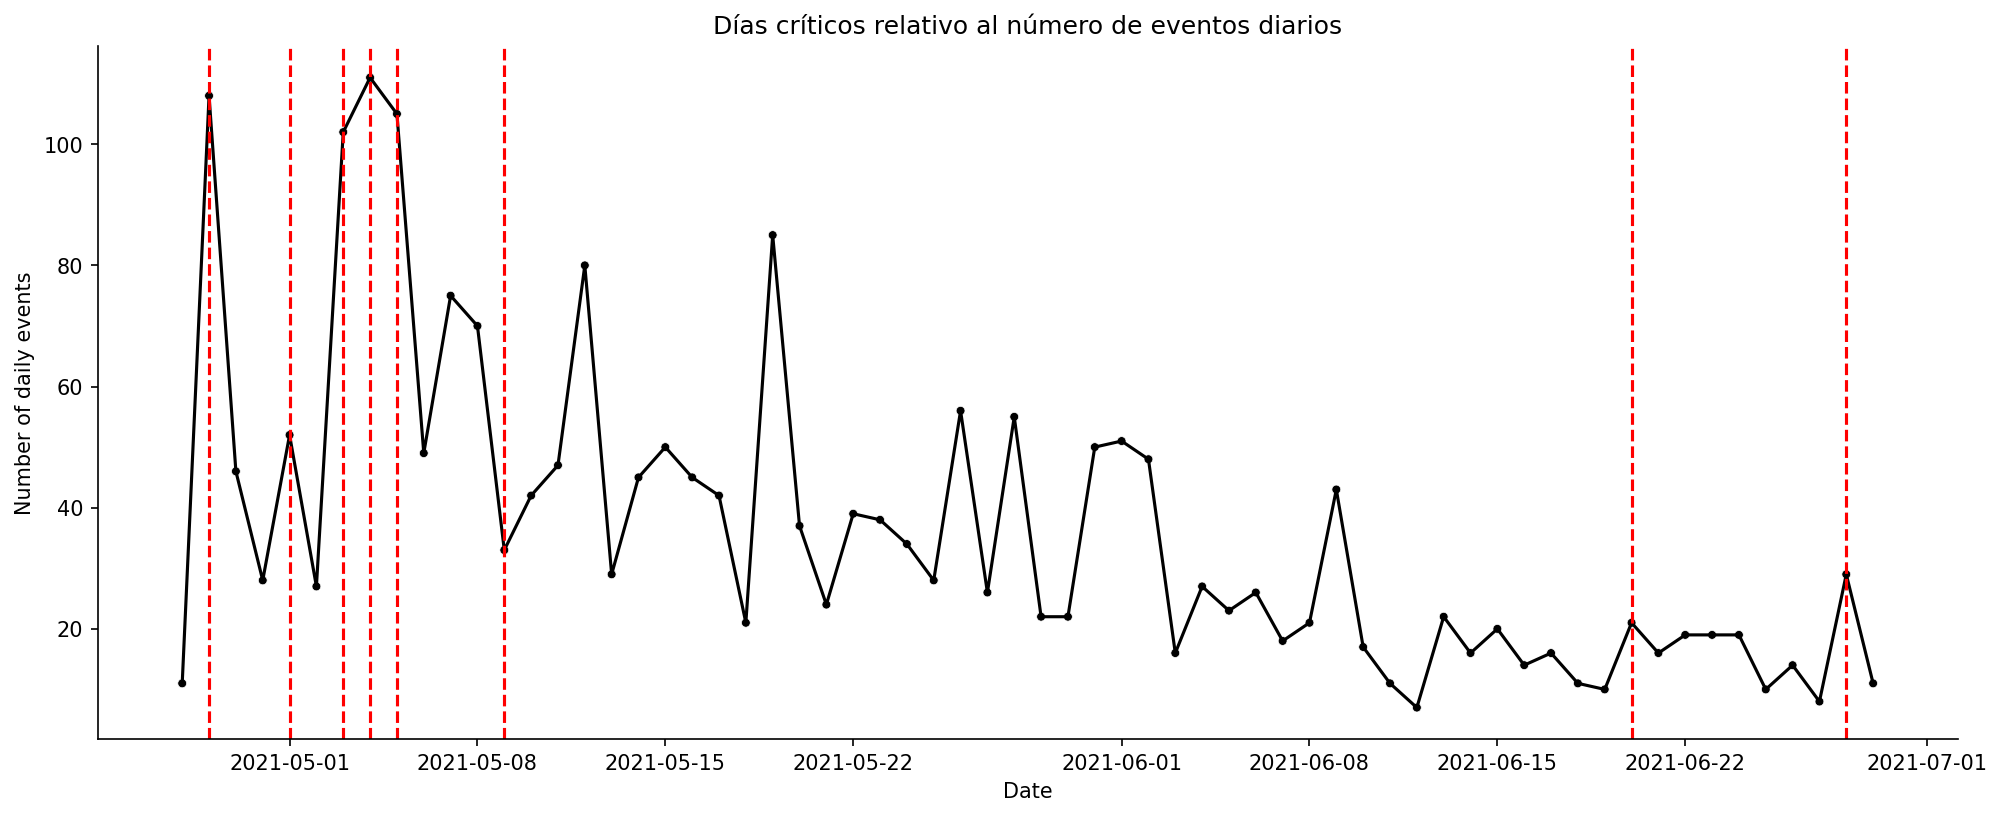

In [31]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = eventos_diarios, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = eventos_diarios, x = "event_date", y = "n", size = 1, color = "black", legend = False, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de eventos diarios");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

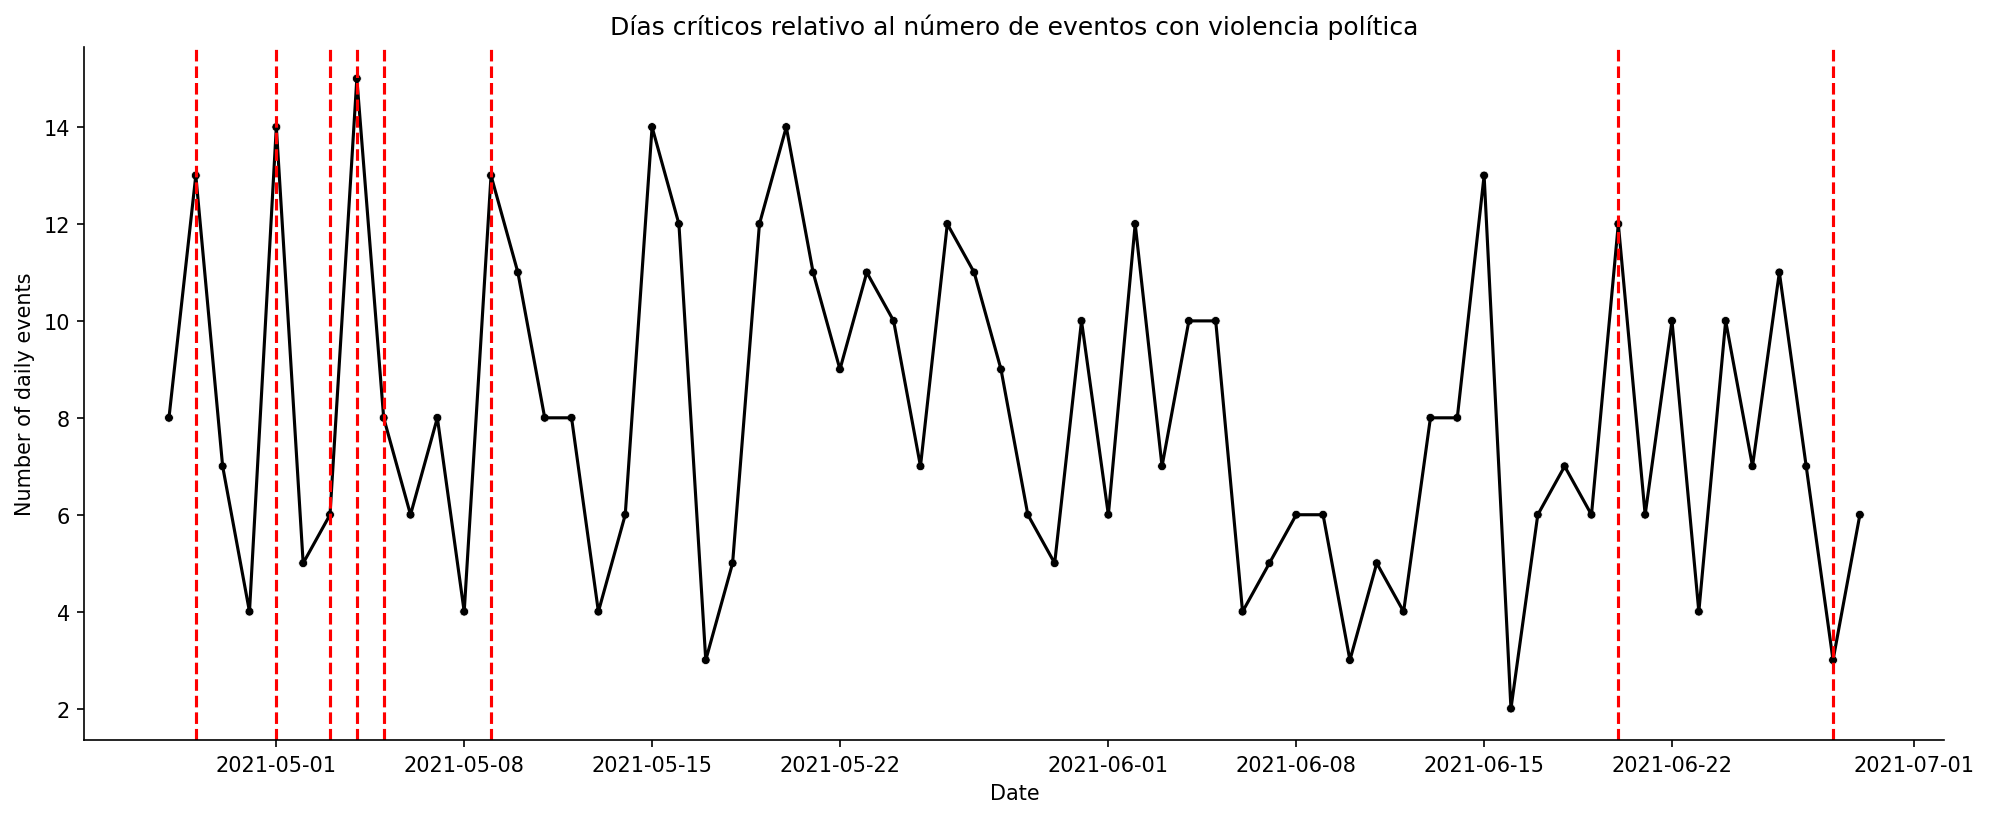

In [32]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_disorder_type2, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = serie_disorder_type2, x = "event_date", y = "n", color = "black",
                legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de eventos con violencia política");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

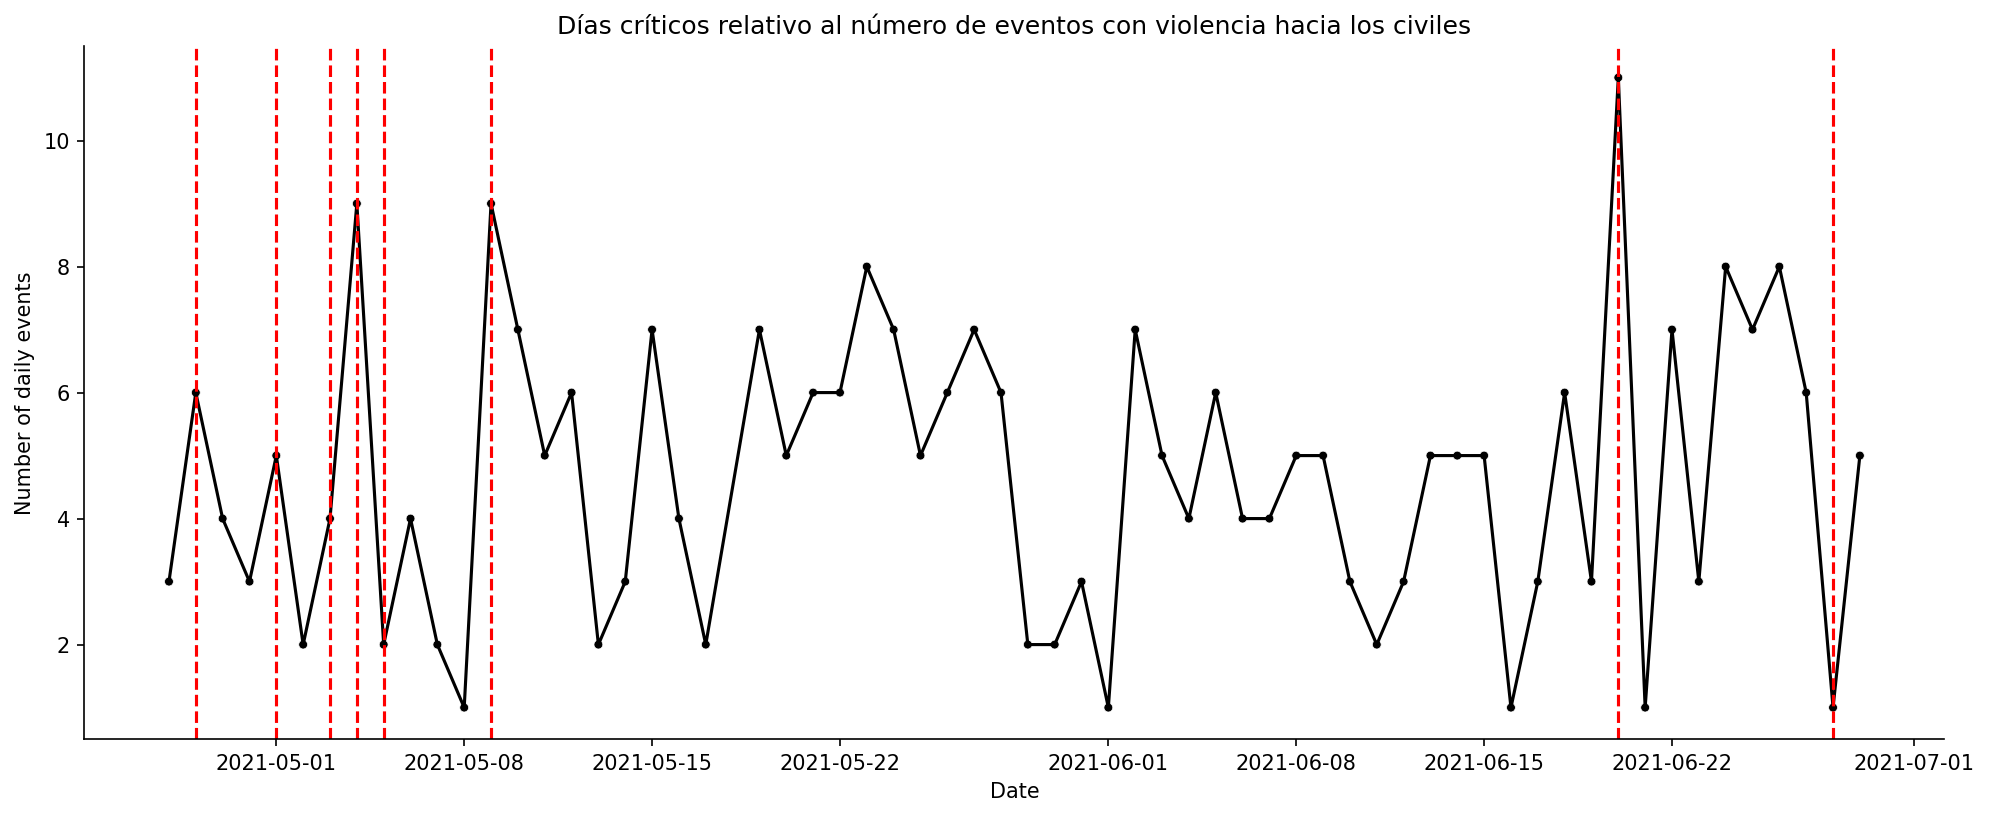

In [33]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_event_type2, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = serie_event_type2, x = "event_date", y = "n", color = "black", 
    legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de eventos con violencia hacia los civiles");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

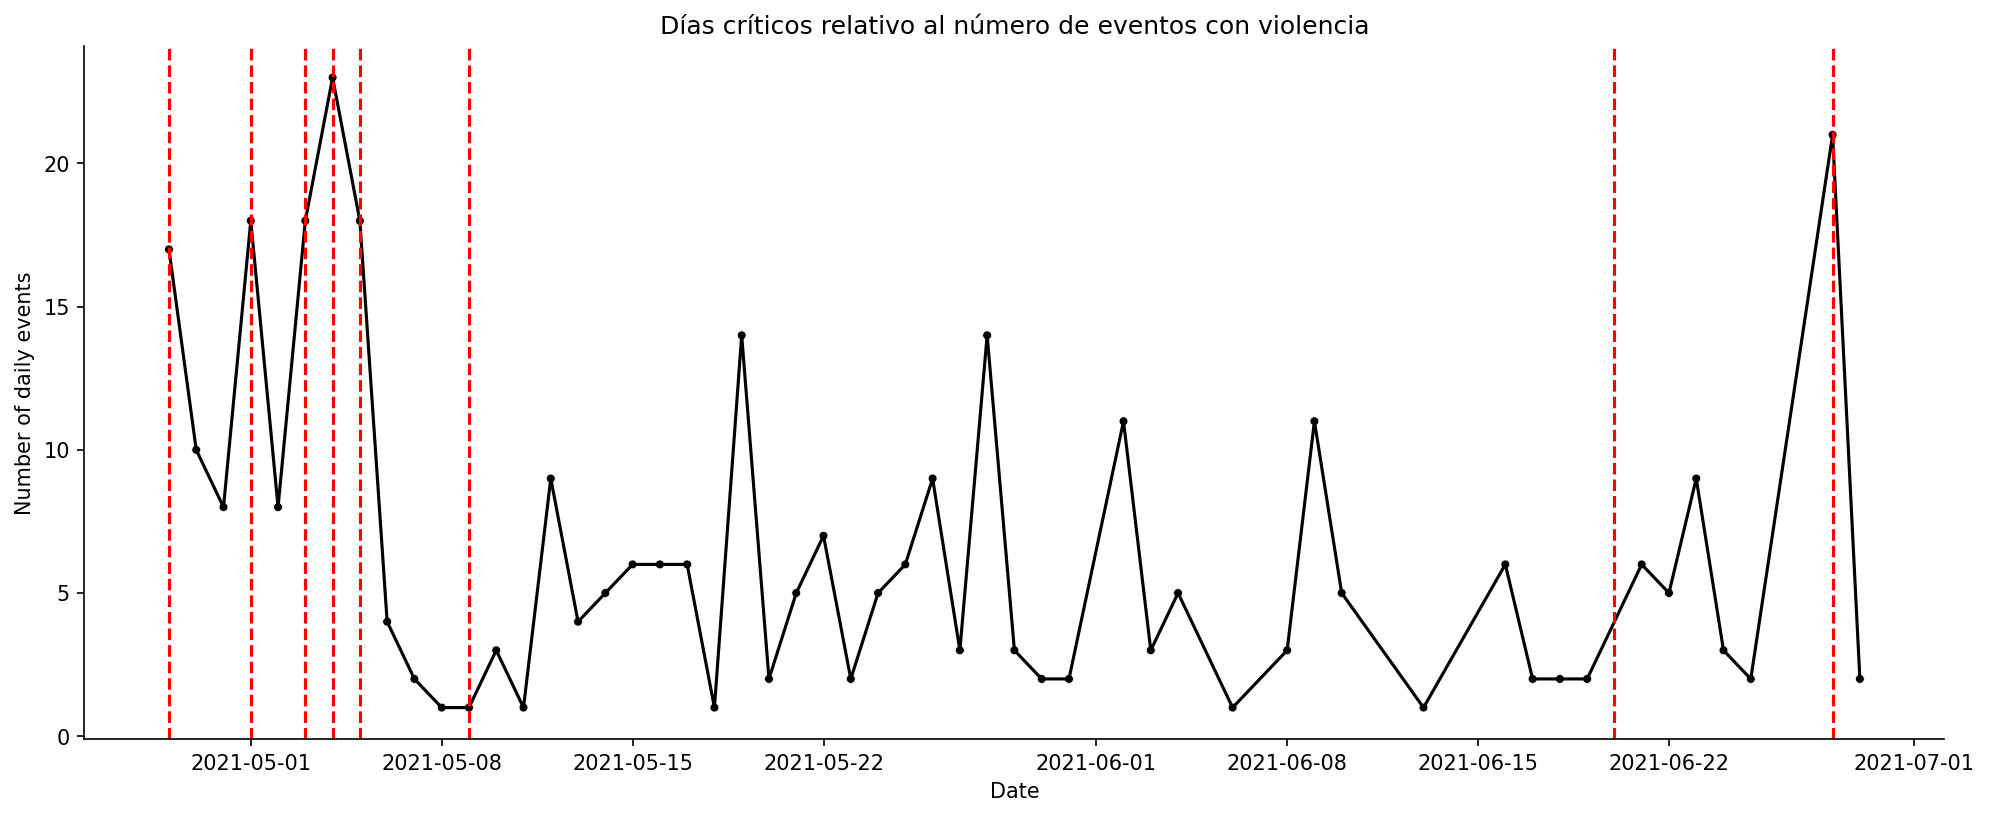

In [34]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_sub_event_type2, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = serie_sub_event_type2, x = "event_date", y = "n", color = "black", 
    legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de eventos con violencia");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

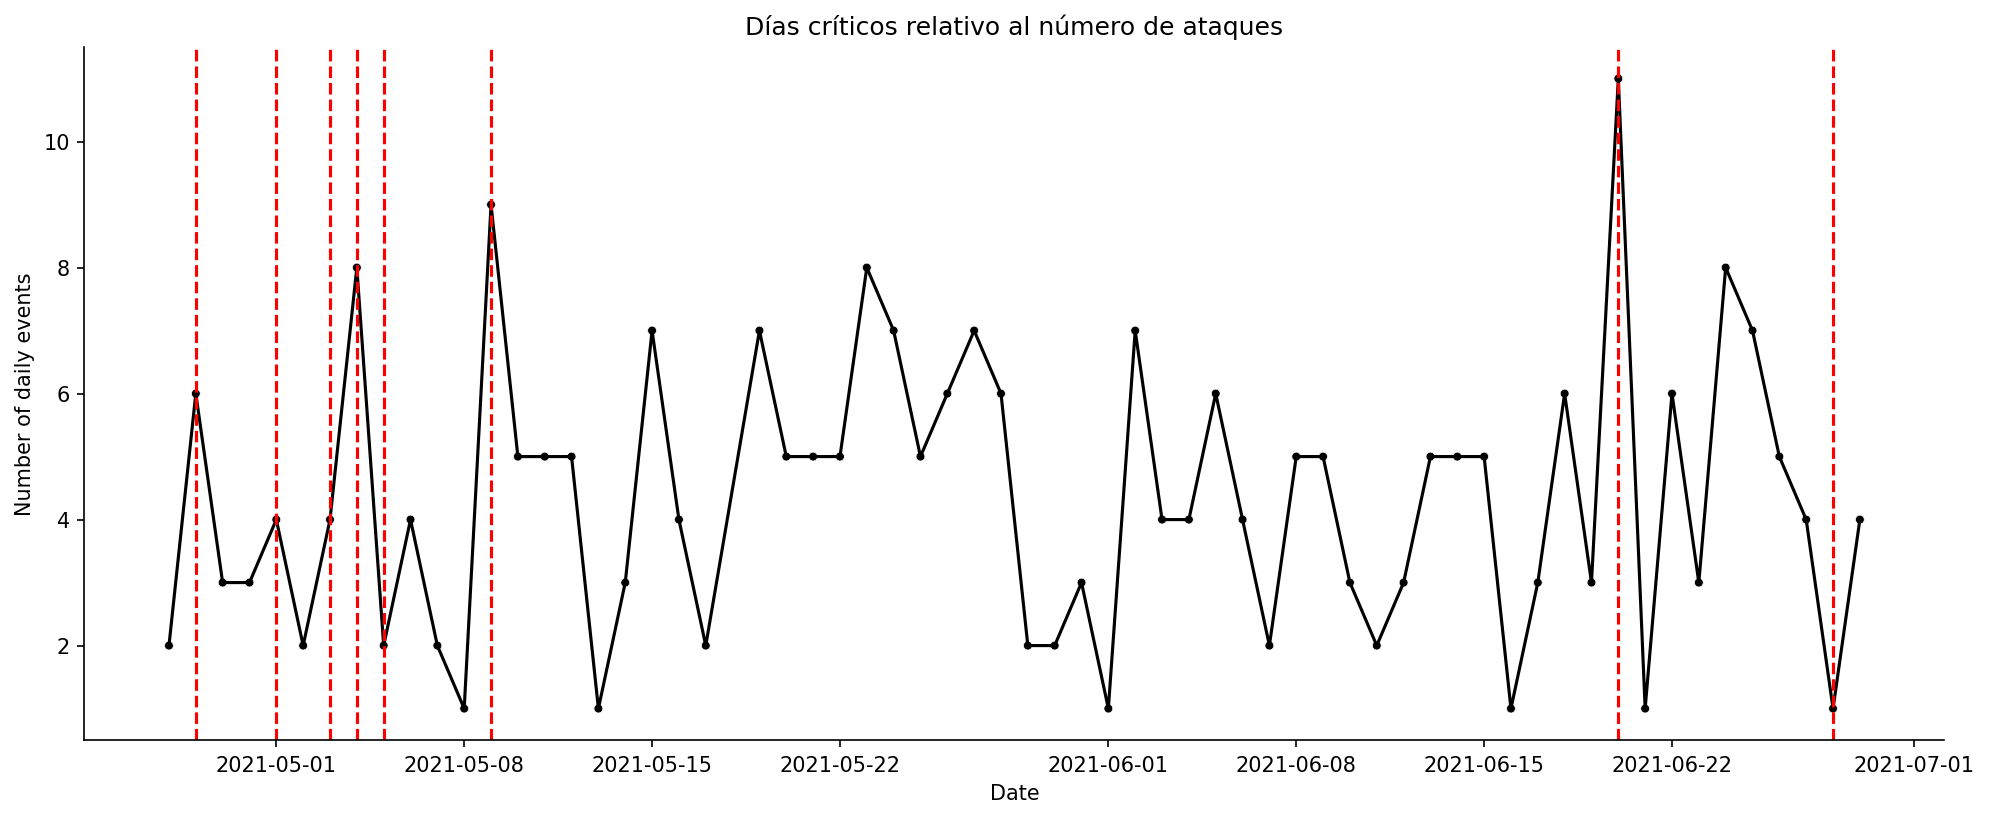

In [35]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_disorder_type3, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = serie_disorder_type3, x = "event_date", y = "n", color = "black", 
    legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de ataques");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

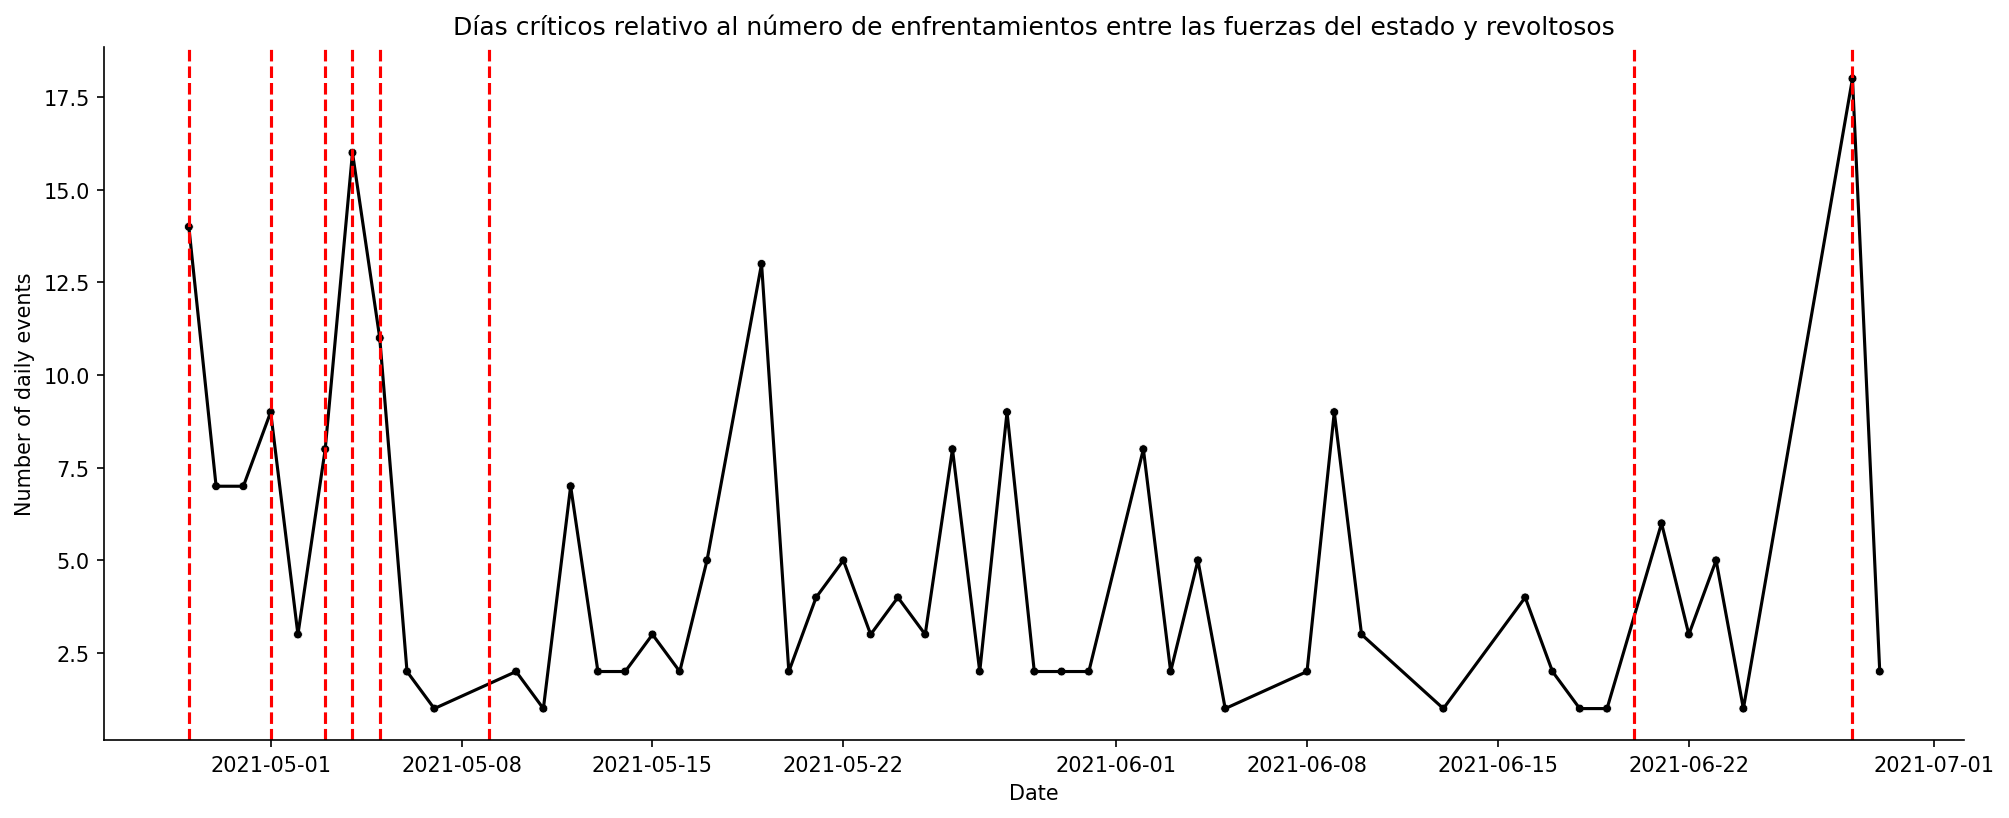

In [39]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_policia_civiles3, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = serie_policia_civiles3, x = "event_date", y = "n", color = "black", 
    legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de enfrentamientos entre las fuerzas del estado y revoltosos");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

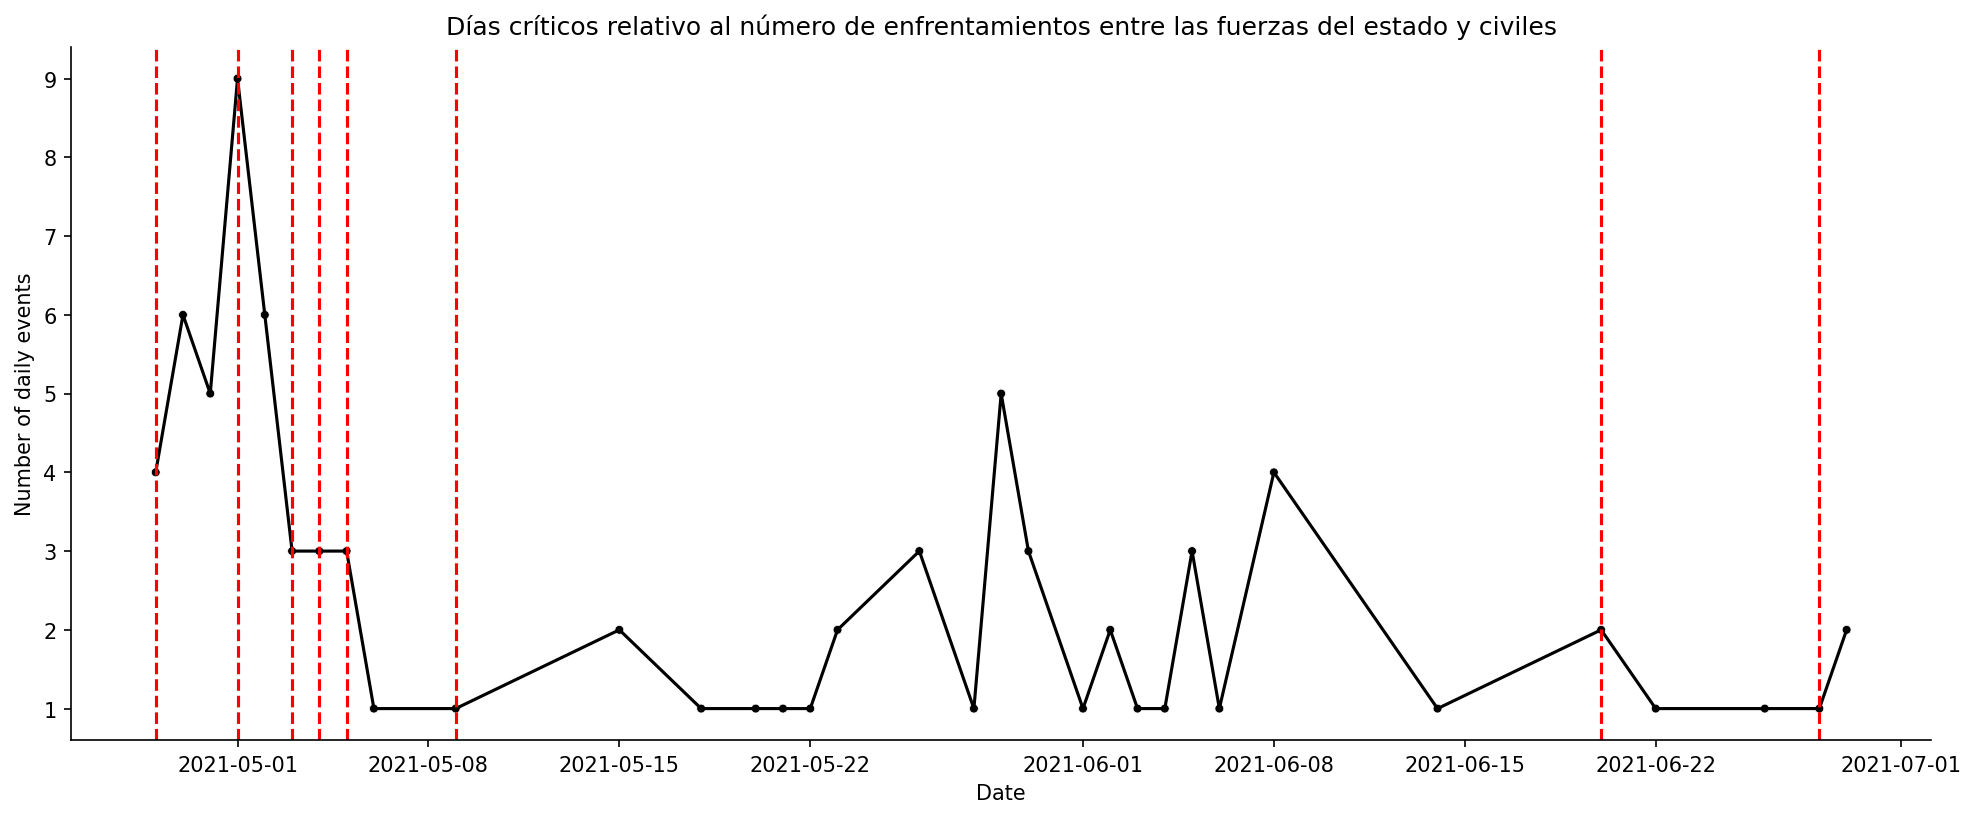

In [40]:
fig, ax = plt.subplots(figsize = (16, 6), dpi = 150)
sns.despine()
sns.lineplot(data = serie_policia_civiles4, x = "event_date", y = "n", color = "black", ax = ax)
sns.scatterplot(data = serie_policia_civiles4, x = "event_date", y = "n", color = "black", 
    legend = False, size = 1, ax = ax)
plt.xlabel("Date")
plt.ylabel("Number of daily events")
plt.title("Días críticos relativo al número de enfrentamientos entre las fuerzas del estado y civiles");

for i in dias_criticos.keys():
    ax.axvline(pd.to_datetime(i), linestyle = '--', color = 'red')

In [198]:
dias_criticos

{'2021-04-28': ['Eventos',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-03': ['Eventos', 'Protestas violentas'],
 '2021-05-04': ['Eventos',
  'Violencia política',
  'Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-05': ['Eventos', 'Protestas violentas'],
 '2021-06-20': ['Violencia contra civiles', 'Ataques'],
 '2021-05-01': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y manifestantes'],
 '2021-06-28': ['Protestas violentas',
  'Enfrentamiento entre fuerzas estatales y revoltosos'],
 '2021-05-09': ['Ataques']}

# Atención

In [115]:
df = pd.read_pickle("../../../Data/Proximity Between Groups/proximidad.gzip", compression = "gzip")
df.head()

,Nodo_ID,Political_Affiliation,Date,Total_RTs,P_Centro,P_Derecha,P_Izquierda,P_Sin Clasificar,P_Mismo,P_Otros
0,0,Sin Clasificar,2021-04-28,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Izquierda,2021-04-28,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Centro,2021-04-28,1.0,0.000000,0.0,0.000000,3.939678,0.000000,1.093606
3,3,Izquierda,2021-04-28,3.0,0.000000,0.0,1.384536,1.313226,1.384536,0.642891
4,4,Izquierda,2021-04-28,28.0,0.417253,0.0,1.928461,0.140703,1.928461,0.137762


In [116]:
df["Date"] = pd.to_datetime(df["Date"])

In [190]:
estadisticas_descriptivas = df.groupby(["Political_Affiliation"])[["Total_RTs", "P_Mismo", "P_Otros"]].agg(["mean", "std", "min", "max"]).round(1)
estadisticas_descriptivas

Total_RTs                   P_Mismo                  \
                           mean   std  min    max    mean  std  min   max   
Political_Affiliation                                                       
Centro                      2.4   7.4  0.0  326.0     5.8  5.0  0.0  14.1   
Derecha                     7.7  18.6  0.0  573.0     4.2  1.9  0.0   7.3   
Izquierda                   6.7  20.1  0.0  705.0     1.7  0.7  0.0   2.6   
Sin Clasificar              0.6   4.3  0.0  303.0     2.2  1.7  0.0   5.1   

                      P_Otros                 
                         mean  std  min  max  
Political_Affiliation                         
Centro                    0.6  0.4  0.0  1.1  
Derecha                   0.3  0.4  0.0  1.3  
Izquierda                 0.5  0.6  0.0  2.4  
Sin Clasificar            0.5  0.6  0.0  1.6

In [197]:
print(estadisticas_descriptivas.to_latex(float_format = "{:.1f}".format))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{Total_RTs} & \multicolumn{4}{r}{P_Mismo} & \multicolumn{4}{r}{P_Otros} \\
 & mean & std & min & max & mean & std & min & max & mean & std & min & max \\
Political_Affiliation &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Centro & 2.4 & 7.4 & 0.0 & 326.0 & 5.8 & 5.0 & 0.0 & 14.1 & 0.6 & 0.4 & 0.0 & 1.1 \\
Derecha & 7.7 & 18.6 & 0.0 & 573.0 & 4.2 & 1.9 & 0.0 & 7.3 & 0.3 & 0.4 & 0.0 & 1.3 \\
Izquierda & 6.7 & 20.1 & 0.0 & 705.0 & 1.7 & 0.7 & 0.0 & 2.6 & 0.5 & 0.6 & 0.0 & 2.4 \\
Sin Clasificar & 0.6 & 4.3 & 0.0 & 303.0 & 2.2 & 1.7 & 0.0 & 5.1 & 0.5 & 0.6 & 0.0 & 1.6 \\
\bottomrule
\end{tabular}



In [117]:
t0_critico = [pd.to_datetime(i) for i in dias_criticos.keys()]
t1_critico = [i + timedelta(days = 1) for i in t0_critico]

In [148]:
[i.weekday() for i in t0_critico]

[2, 0, 1, 2, 6, 5, 0, 6]

In [118]:
df["t0_critico"] = df["Date"].isin(t0_critico)
df["t1_critico"] = df["Date"].isin(t1_critico)

In [133]:
df["day_number"] = df["Date"].dt.weekday
df["day_number"] = df["day_number"].astype(str)
df["Nodo_ID"] = df["Nodo_ID"].astype(str)
df["weekend"] = np.where(df["Date"].dt.weekday >= 5, True, False)

In [177]:
modelo1 = smf.ols(formula = "Total_RTs ~ t0_critico", data = df).fit(cov_type = 'HC3')
modelo2 = smf.ols(formula = "Total_RTs ~ t0_critico + t1_critico", data = df).fit(cov_type = 'HC3')
modelo3 = smf.ols(formula = "Total_RTs ~ t0_critico + t1_critico + weekend", data = df).fit(cov_type = 'HC3')
modelo4 = smf.ols(formula = "Total_RTs ~ t0_critico + t1_critico + day_number", data = df).fit(cov_type = 'HC3')
modelo5 = smf.ols(formula = "Total_RTs ~ t0_critico + t1_critico + weekend + Political_Affiliation", data = df).fit(cov_type = 'HC3')

In [201]:
stargazer1 = Stargazer([modelo1, modelo2, modelo3, modelo4, modelo5])
stargazer1.dependent_variable_name = "Total RTs"
stargazer1.covariate_order(["Intercept", "t0_critico[T.True]", "t1_critico[T.True]", "Political_Affiliation[T.Derecha]",
    "Political_Affiliation[T.Izquierda]", "Political_Affiliation[T.Sin Clasificar]", "weekend[T.True]", "day_number[T.1]",
    "day_number[T.2]", "day_number[T.3]", "day_number[T.4]", "day_number[T.5]", "day_number[T.6]"])
stargazer1.rename_covariates({
    "t0_critico[T.True]": "Critical day (t)", 
    "t1_critico[T.True]": "Critical day (t+1)",
    "weekend[T.True]": "Weekend",
    "day_number[T.1]": "Tuesday",
    "day_number[T.2]": "Wednesday",
    "day_number[T.3]": "Thursday",
    "day_number[T.4]": "Friday",
    "day_number[T.5]": "Saturday",
    "day_number[T.6]": "Sunday",
    "Political_Affiliation[T.Derecha]": "Political Affiliation: Right",
    "Political_Affiliation[T.Izquierda]": "Political Affiliation: Left",
    "Political_Affiliation[T.Sin Clasificar]": "Political Affiliation: Unknown"
    })
stargazer1.add_custom_notes(["Robust standard errors in parentheses"])
stargazer1

In [203]:
print(stargazer1.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{5}{c}{\textit{Dependent variable: Total_RTs}} \
\cr \cline{2-6}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\
\hline \\[-1.8ex]
 Intercept & 5.519$^{***}$ & 5.281$^{***}$ & 5.356$^{***}$ & 4.886$^{***}$ & 1.867$^{***}$ \\
& (0.012) & (0.012) & (0.015) & (0.035) & (0.019) \\
 Critical day (t) & 3.150$^{***}$ & 2.843$^{***}$ & 2.876$^{***}$ & 2.985$^{***}$ & 2.876$^{***}$ \\
& (0.048) & (0.047) & (0.047) & (0.049) & (0.047) \\
 Critical day (t+1) & & 2.182$^{***}$ & 2.130$^{***}$ & 2.384$^{***}$ & 2.130$^{***}$ \\
& & (0.043) & (0.044) & (0.045) & (0.044) \\
 Political Affiliation: Right & & & & & 5.231$^{***}$ \\
& & & & & (0.032) \\
 Political Affiliation: Left & & & & & 4.314$^{***}$ \\
& & & & & (0.023) \\
 Political Affiliation: Unknown & & & & & -1.823$^{***}$ \\
& & & & & (0.018) \\
 Weekend & & & -0.254$^{***}$ & & -0.254$^{***}$ \\
& & & (0.027) & & (0.026)

In [200]:
modelo6 = smf.ols(formula = "P_Mismo ~ t0_critico", data = df).fit(cov_type = 'HC3')
modelo7 = smf.ols(formula = "P_Mismo ~ t0_critico + t1_critico", data = df).fit(cov_type = 'HC3')
modelo8 = smf.ols(formula = "P_Mismo ~ t0_critico + t1_critico + weekend", data = df).fit(cov_type = 'HC3')
modelo9 = smf.ols(formula = "P_Mismo ~ t0_critico + t1_critico + day_number", data = df).fit(cov_type = 'HC3')
modelo10 = smf.ols(formula = "P_Mismo ~ t0_critico + t1_critico + weekend + Political_Affiliation", data = df).fit(cov_type = 'HC3')

stargazer2 = Stargazer([modelo6, modelo7, modelo8, modelo9, modelo10])
stargazer2.dependent_variable_name = "Inner proximity"
stargazer2.covariate_order(["Intercept", "t0_critico[T.True]", "t1_critico[T.True]", "Political_Affiliation[T.Derecha]",
    "Political_Affiliation[T.Izquierda]", "Political_Affiliation[T.Sin Clasificar]", "weekend[T.True]", "day_number[T.1]",
    "day_number[T.2]", "day_number[T.3]", "day_number[T.4]", "day_number[T.5]", "day_number[T.6]"])
stargazer2.rename_covariates({
    "P_Mismo": "Inner proximity",
    "t0_critico[T.True]": "Critical day (t)", 
    "t1_critico[T.True]": "Critical day (t+1)",
    "weekend[T.True]": "Weekend",
    "day_number[T.1]": "Tuesday",
    "day_number[T.2]": "Wednesday",
    "day_number[T.3]": "Thursday",
    "day_number[T.4]": "Friday",
    "day_number[T.5]": "Saturday",
    "day_number[T.6]": "Sunday",
    "Political_Affiliation[T.Derecha]": "Political Affiliation: Right",
    "Political_Affiliation[T.Izquierda]": "Political Affiliation: Left",
    "Political_Affiliation[T.Sin Clasificar]": "Political Affiliation: Unknown"
    })
stargazer2.add_custom_notes(["Robust standard errors in parentheses"])
stargazer2

In [204]:
print(stargazer2.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{5}{c}{\textit{Dependent variable: P_Mismo}} \
\cr \cline{2-6}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\
\hline \\[-1.8ex]
 Intercept & 2.590$^{***}$ & 2.596$^{***}$ & 2.610$^{***}$ & 2.643$^{***}$ & 5.795$^{***}$ \\
& (0.002) & (0.002) & (0.003) & (0.006) & (0.015) \\
 Critical day (t) & -0.101$^{***}$ & -0.092$^{***}$ & -0.086$^{***}$ & -0.092$^{***}$ & -0.066$^{***}$ \\
& (0.006) & (0.006) & (0.006) & (0.006) & (0.005) \\
 Critical day (t+1) & & -0.051$^{***}$ & -0.060$^{***}$ & -0.070$^{***}$ & -0.028$^{***}$ \\
& & (0.006) & (0.006) & (0.006) & (0.005) \\
 Political Affiliation: Right & & & & & -1.576$^{***}$ \\
& & & & & (0.016) \\
 Political Affiliation: Left & & & & & -4.109$^{***}$ \\
& & & & & (0.015) \\
 Political Affiliation: Unknown & & & & & -3.596$^{***}$ \\
& & & & & (0.018) \\
 Weekend & & & -0.051$^{***}$ & & -0.040$^{***}$ \\
& & & (0.005) & 

In [202]:
modelo11 = smf.ols(formula = "P_Otros ~ t0_critico", data = df).fit(cov_type = 'HC3')
modelo12 = smf.ols(formula = "P_Otros ~ t0_critico + t1_critico", data = df).fit(cov_type = 'HC3')
modelo13 = smf.ols(formula = "P_Otros ~ t0_critico + t1_critico + weekend", data = df).fit(cov_type = 'HC3')
modelo14 = smf.ols(formula = "P_Otros ~ t0_critico + t1_critico + day_number", data = df).fit(cov_type = 'HC3')
modelo15 = smf.ols(formula = "P_Otros ~ t0_critico + t1_critico + weekend + Political_Affiliation", data = df).fit(cov_type = 'HC3')

stargazer3 = Stargazer([modelo11, modelo12, modelo13, modelo14, modelo15])
stargazer3.dependent_variable_name = "Inner proximity"
stargazer3.covariate_order(["Intercept", "t0_critico[T.True]", "t1_critico[T.True]", "Political_Affiliation[T.Derecha]",
    "Political_Affiliation[T.Izquierda]", "Political_Affiliation[T.Sin Clasificar]", "weekend[T.True]", "day_number[T.1]",
    "day_number[T.2]", "day_number[T.3]", "day_number[T.4]", "day_number[T.5]", "day_number[T.6]"])
stargazer3.rename_covariates({
    "P_Otros": "Outer proximity",
    "t0_critico[T.True]": "Critical day (t)", 
    "t1_critico[T.True]": "Critical day (t+1)",
    "weekend[T.True]": "Weekend",
    "day_number[T.1]": "Tuesday",
    "day_number[T.2]": "Wednesday",
    "day_number[T.3]": "Thursday",
    "day_number[T.4]": "Friday",
    "day_number[T.5]": "Saturday",
    "day_number[T.6]": "Sunday",
    "Political_Affiliation[T.Derecha]": "Political Affiliation: Right",
    "Political_Affiliation[T.Izquierda]": "Political Affiliation: Left",
    "Political_Affiliation[T.Sin Clasificar]": "Political Affiliation: Unknown"
    })
stargazer3.add_custom_notes(["Robust standard errors in parentheses"])
stargazer3

In [205]:
print(stargazer3.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{5}{c}{\textit{Dependent variable: P_Otros}} \
\cr \cline{2-6}
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\
\hline \\[-1.8ex]
 Intercept & 0.431$^{***}$ & 0.427$^{***}$ & 0.432$^{***}$ & 0.413$^{***}$ & 0.574$^{***}$ \\
& (0.000) & (0.001) & (0.001) & (0.001) & (0.001) \\
 Critical day (t) & 0.054$^{***}$ & 0.047$^{***}$ & 0.050$^{***}$ & 0.050$^{***}$ & 0.047$^{***}$ \\
& (0.001) & (0.001) & (0.001) & (0.001) & (0.001) \\
 Critical day (t+1) & & 0.037$^{***}$ & 0.034$^{***}$ & 0.035$^{***}$ & 0.031$^{***}$ \\
& & (0.001) & (0.001) & (0.001) & (0.001) \\
 Political Affiliation: Right & & & & & -0.248$^{***}$ \\
& & & & & (0.002) \\
 Political Affiliation: Left & & & & & -0.130$^{***}$ \\
& & & & & (0.001) \\
 Political Affiliation: Unknown & & & & & -0.043$^{***}$ \\
& & & & & (0.004) \\
 Weekend & & & -0.017$^{***}$ & & -0.017$^{***}$ \\
& & & (0.001) & & (0.001)